In [1]:
import xarray as xr
import pandas as pd
%matplotlib inline
from datacube.storage.masking import mask_invalid_data
from datacube.storage.storage import write_dataset_to_netcdf

# install standard_precip module and save under /home/563/sl1412
import sys
sys.path.append('/home/563/sl1412/standard_precip/')
import standard_precip

from standard_precip.spi import SPI 

from __future__ import absolute_import, division, print_function, unicode_literals
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np

In [2]:
# a function to create datelist (monthly)
def create_datelist(start_date, n_months):
    
    dates = [start_date + relativedelta(months=i) 
              for i in range(0, n_months)]
    
    return np.array(dates)

In [4]:
rainfall = xr.open_dataset('/g/data/oe9/project/team-drip/Rainfall/daily_rainfall_MDB_1960_2013.nc')
rainfall

<xarray.Dataset>
Dimensions:    (latitude: 270, longitude: 280, time: 19723)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 1960-01-03 ...
  * latitude   (latitude) float64 -24.52 -24.57 -24.62 -24.67 -24.72 -24.77 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
Data variables:
    crs        int32 ...
    rainfall   (time, latitude, longitude) float64 ...
Attributes:
    date_created:           2018-01-18T15:08:41.816164
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.5.4...
    geospatial_bounds:      POLYGON ((138.5 -24.5,138.5 -38.0,152.5 -38.0,152...
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -38.0
    geospatial_lat_max:     -24.5
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     138.5
    geospatial_lon_max:     152.5
    geospatial_lon_units:   degrees_east

In [5]:
# calculate monthly rainfall 
Rain_month=rainfall.resample(time="1M").sum()

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [7]:
def calc_spi(rainfall_data, axis=None):
    
    out = rainfall_data.copy()
    
    if isinstance(rainfall_data, xr.DataArray):
        rainfall_data = rainfall_data.values
    
    #loc_NaNs = isnan(rainfall_data)
    #rainfall_data[loc_NaNs] = 0
    # Initialize SPI class
    spi = SPI() 
    # Set rolling window parameters
    spi.set_rolling_window_params(span=3, window_type='blackman', center=True)
    # Set distribution parameters
    spi.set_distribution_params(dist_type='gamma')
    # Calculate SPI
    out[:] = spi.calculate(rainfall_data, starting_month=1).squeeze()
    return out

In [8]:
a= Rain_month.rainfall.isel(latitude=0, longitude=0)
a

<xarray.DataArray 'rainfall' (time: 648)>
array([  1.019882e+01,   3.044697e+01,   1.387126e-02, ...,   2.461503e-10,
         2.830035e+00,   7.350011e+00])
Coordinates:
  * time       (time) datetime64[ns] 1960-01-31 1960-02-29 1960-03-31 ...
    latitude   float64 -24.52
    longitude  float64 138.5

In [9]:
calc_spi(a)

<xarray.DataArray 'rainfall' (time: 648)>
array([      nan,  0.797007, -1.423524, ..., -5.283412, -0.037943,       nan])
Coordinates:
  * time       (time) datetime64[ns] 1960-01-31 1960-02-29 1960-03-31 ...
    latitude   float64 -24.52
    longitude  float64 138.5

In [11]:
%%time

SPI_data = xr.apply_ufunc(
    calc_spi,
    Rain_month.rainfall,
    input_core_dims=[('time',)],
    output_core_dims=[('dim0',)],
    vectorize=True,
    
)

CPU times: user 16h 56min 42s, sys: 1min 28s, total: 16h 58min 10s
Wall time: 16h 56min 31s


In [22]:
SPI_data = SPI_data.rename('SPI_3M')
#SPI_data = SPI_data.rename(dict(dim0='time'))
SPI_data['time'] = Rain_month.rainfall.time.data
SPI_data

<xarray.DataArray 'SPI_3M' (latitude: 270, longitude: 280, time: 648)>
array([[[      nan,  0.797007, ..., -0.037943,       nan],
        [      nan,  0.747181, ...,  0.092809,       nan],
        ..., 
        [      nan,  0.39688 , ..., -0.304778,       nan],
        [      nan,  0.422357, ..., -0.333351,       nan]],

       [[      nan,  0.715338, ..., -0.192817,       nan],
        [      nan,  0.781334, ..., -0.218891,       nan],
        ..., 
        [      nan,  0.500557, ..., -0.340252,       nan],
        [      nan,  0.401191, ..., -0.372423,       nan]],

       ..., 
       [[      nan,  1.9535  , ..., -0.157481,       nan],
        [      nan,  2.196282, ..., -0.157762,       nan],
        ..., 
        [      nan, -1.155512, ...,  1.23463 ,       nan],
        [      nan, -1.237455, ...,  1.237827,       nan]],

       [[      nan,  2.420869, ..., -0.15614 ,       nan],
        [      nan,  2.451742, ..., -0.15593 ,       nan],
        ..., 
        [      nan, -1.31188

In [23]:
a = SPI_data.to_netcdf
a

<bound method DataArray.to_netcdf of <xarray.DataArray 'SPI_3M' (latitude: 270, longitude: 280, time: 648)>
array([[[      nan,  0.797007, ..., -0.037943,       nan],
        [      nan,  0.747181, ...,  0.092809,       nan],
        ..., 
        [      nan,  0.39688 , ..., -0.304778,       nan],
        [      nan,  0.422357, ..., -0.333351,       nan]],

       [[      nan,  0.715338, ..., -0.192817,       nan],
        [      nan,  0.781334, ..., -0.218891,       nan],
        ..., 
        [      nan,  0.500557, ..., -0.340252,       nan],
        [      nan,  0.401191, ..., -0.372423,       nan]],

       ..., 
       [[      nan,  1.9535  , ..., -0.157481,       nan],
        [      nan,  2.196282, ..., -0.157762,       nan],
        ..., 
        [      nan, -1.155512, ...,  1.23463 ,       nan],
        [      nan, -1.237455, ...,  1.237827,       nan]],

       [[      nan,  2.420869, ..., -0.15614 ,       nan],
        [      nan,  2.451742, ..., -0.15593 ,       nan],
     

In [25]:
path = '/g/data/oe9/project/team-drip/Rainfall/SPI_3M.nc'
SPI_data.to_netcdf(path, mode = 'w')

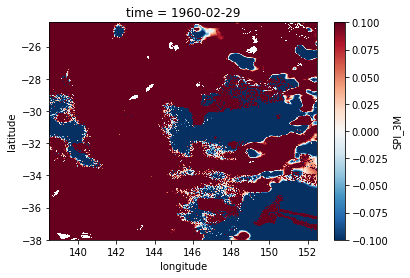

In [26]:
SPI_data.isel(time=1).plot.imshow() # selection of time = 1

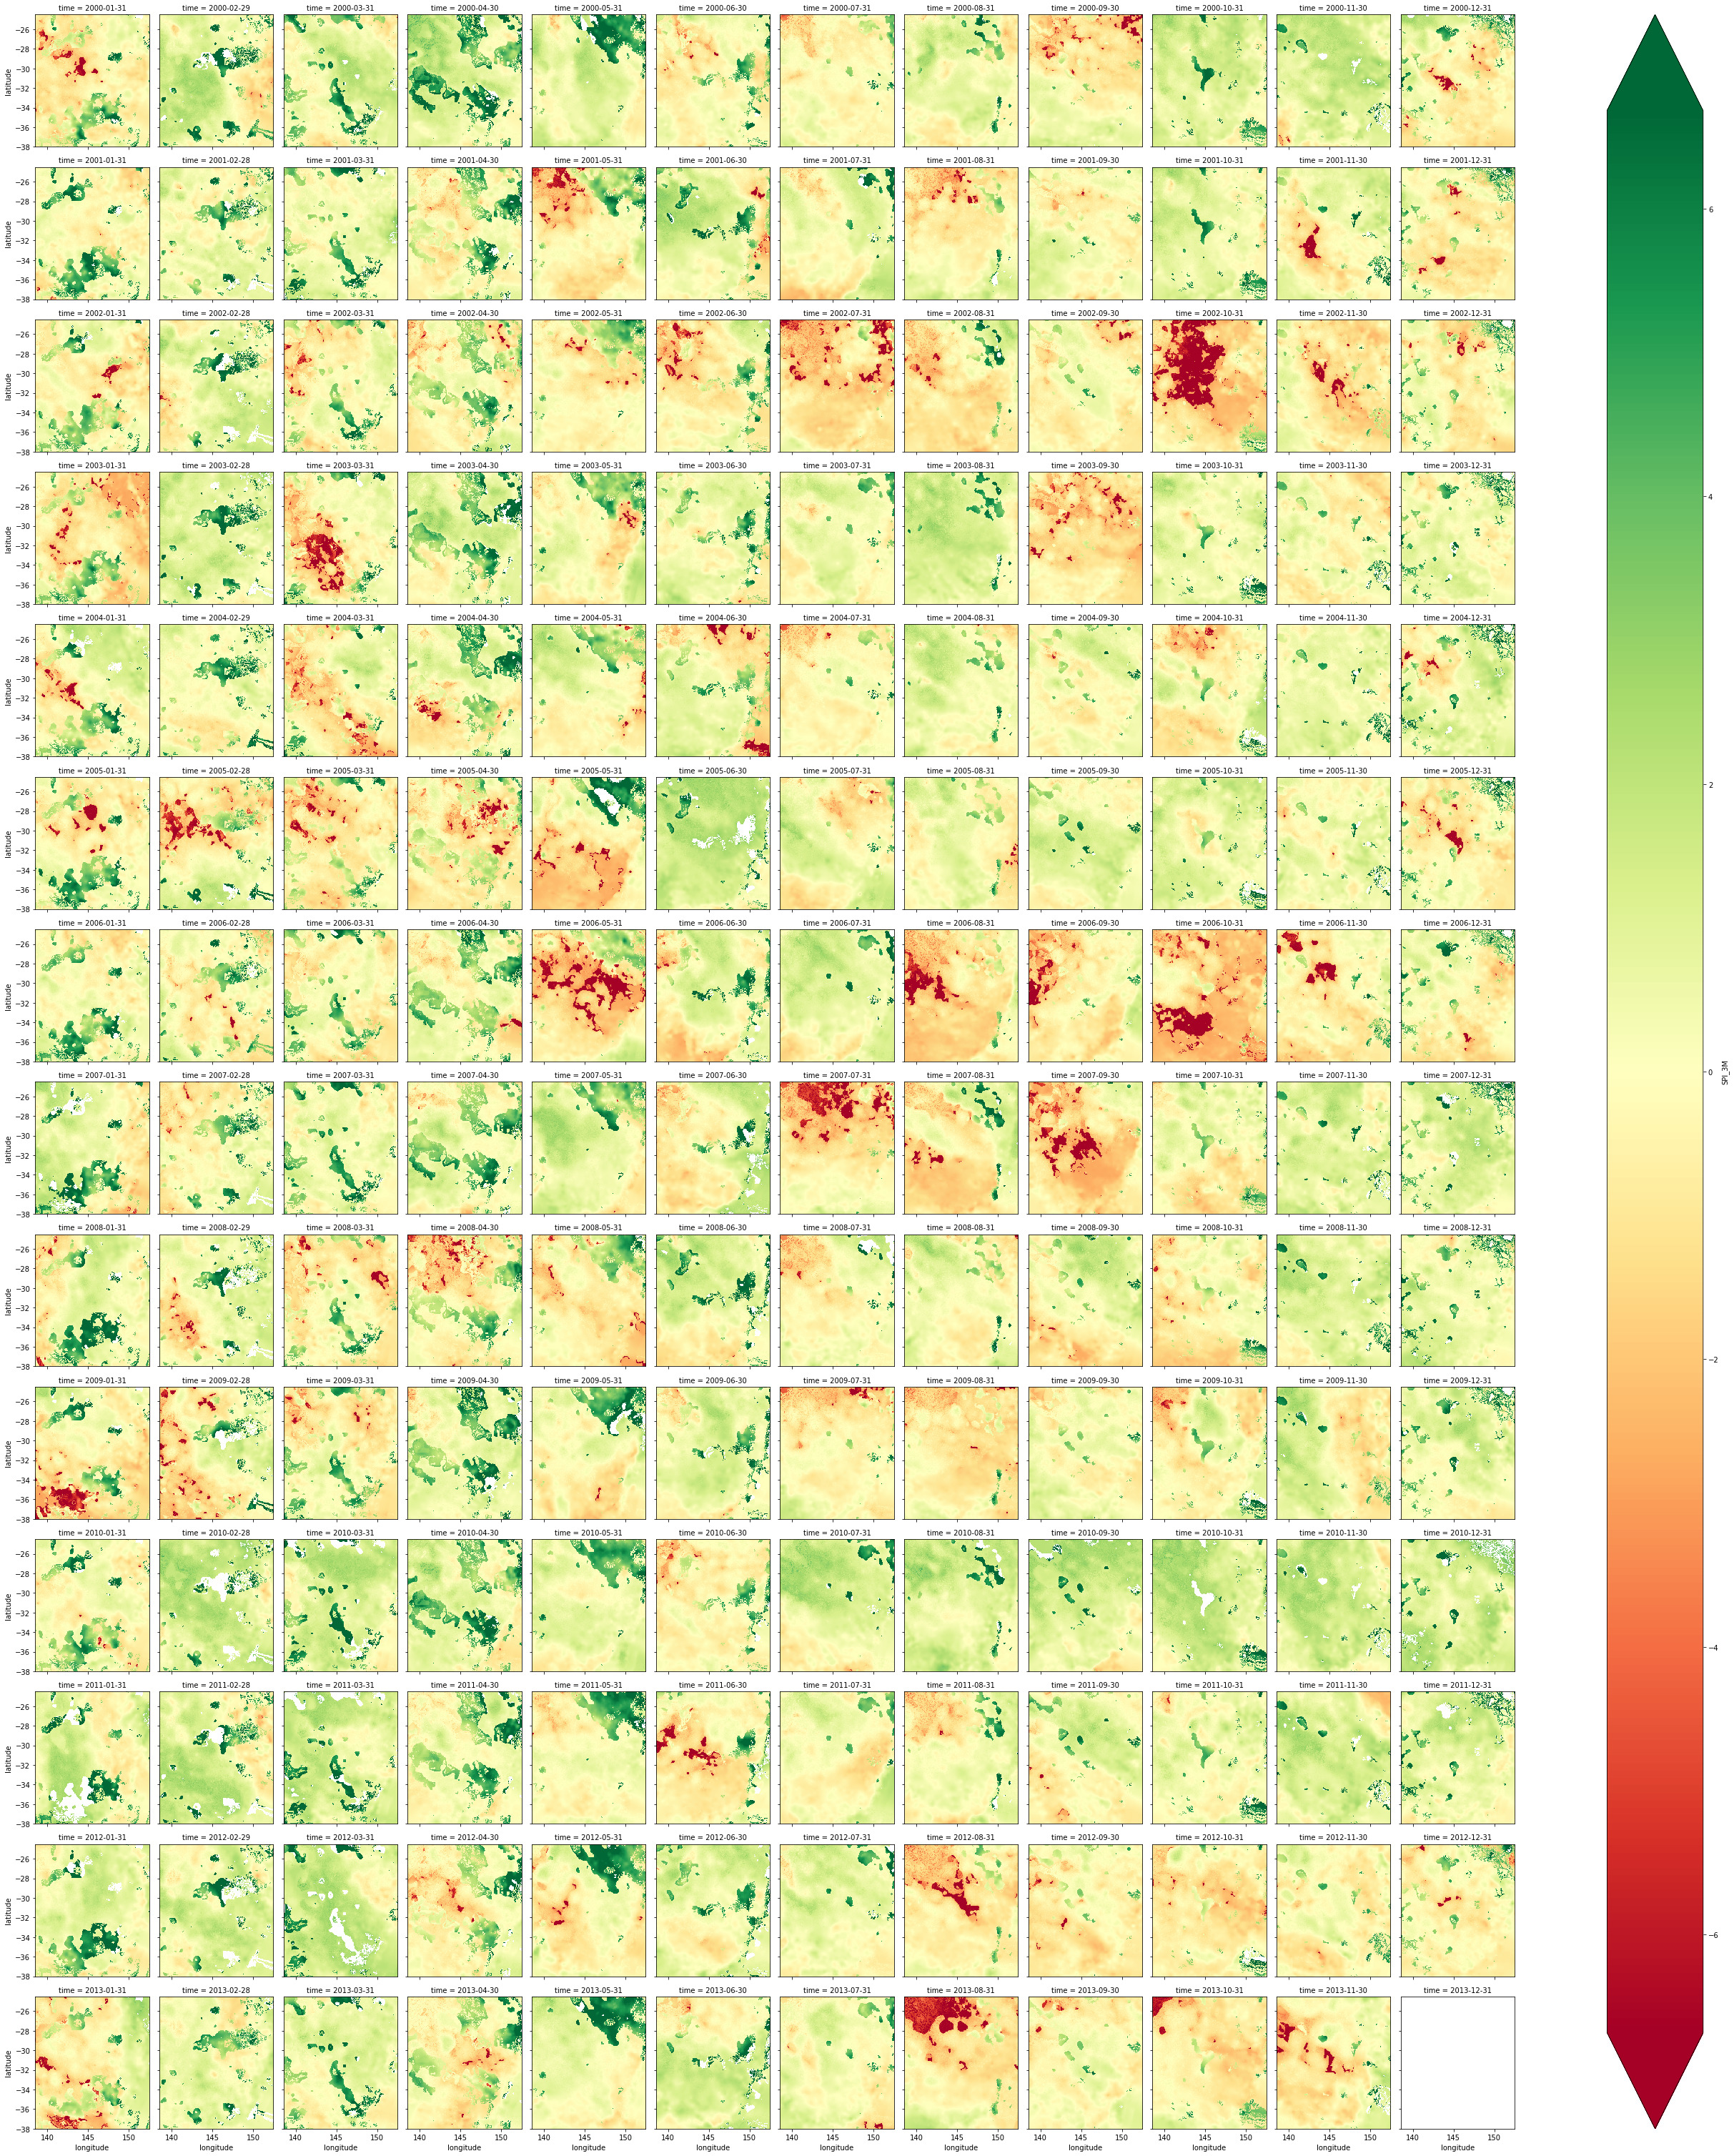

In [27]:
SPI_data.isel(time=range(480,648)).plot.imshow(col='time', robust = True, col_wrap=12, cmap = 'RdYlGn')